# NLP punctuation feature engineering

This notebook looks at how to optimize punctuation feature engineering for a Kaggle [essay scoring competition](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2). It turns out that using a count of all punctuation types can reduce effectiveness by adding unnecessary noise. In this case, using only the 3 types of punctuation with the strongest correlation to essays scores proves most effective. 

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Check all types of punctuation

First, we check the correlation of various different types of punctuation with the y variable, essay scores. Then we fit a random forest model and check the average Cohen Kappa score using all of these features (0.416). 

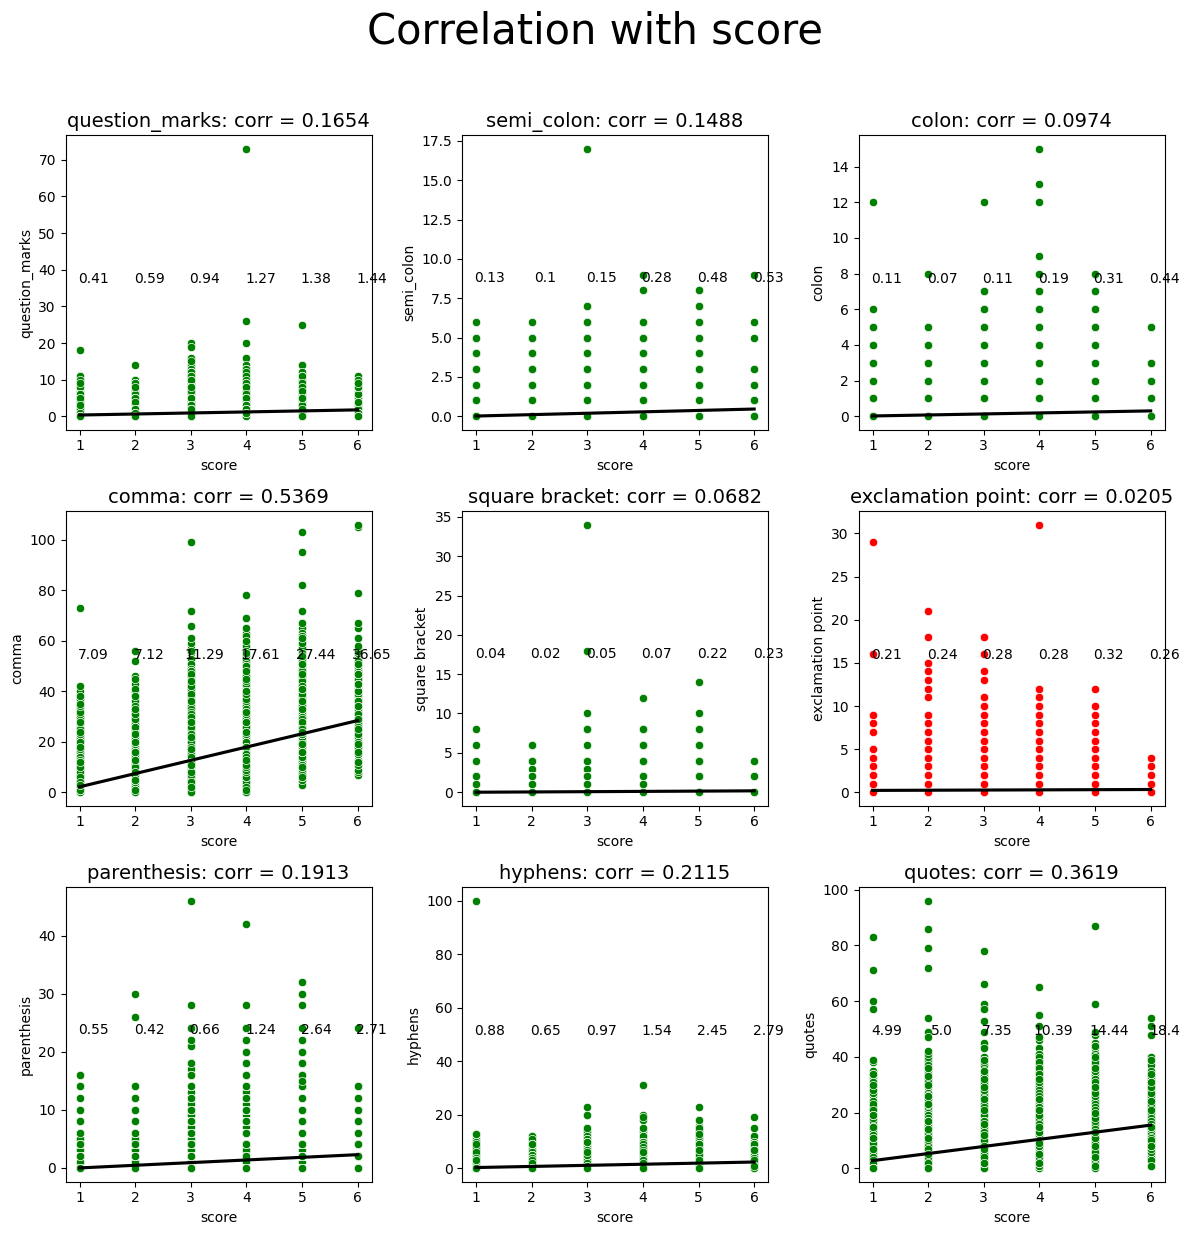

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# returns a count of punctuation in a given essay
def count_punctuation(x, punc): 
    return sum([1 for j in x if j in punc])

# lists different types of punctuation and their names
punctuation = [['?'], [';'], [':'], [','], ['[', ']'], ['!'], ['(', ')'], ['-'], ['\'', '"']]
names = ['question_marks', 'semi_colon', 'colon', 'comma', 'square bracket', 'exclamation point', 
         'parenthesis', 'hyphens', 'quotes']

# creates a new feature for the count of each type of punctuation
for i, punc in enumerate(punctuation):
    train[names[i]] = [count_punctuation(x, punc) for x in train['full_text']]
    
    
# returns whether a set of values largely rise or fall in a linear fashion
def linear(values):
    current = 0 
    positive = []
    negative = []
    for val in values:
        if val > current:
            positive.append(True)
            negative.append(False)
            current = val 
        else:
            positive.append(False)
            negative.append(True)
            current = val 
                
    return (sum(positive)>=5) or (sum(negative)>=4)


# defines y for use in a scatterplot below
y = train['score']


# analyses the relationship between set of features and the y variable
def correlation_analysis(data, var, ncols=3, height=4, title=None):

    # defines plot for only 1 column
    if ncols == 1:

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6)) # creates a subplot object
        avg_x = data.groupby('score')[var].mean().reset_index().iloc[:,1] # calculates an average value at each score level (1-6) 
        corr = round(stats.pearsonr(data[var], y)[0], 4) # determines the correlation of the feature to y
        linear_trend = linear(avg_x) # determines whether relationship to score is largely linear or not
        
        if (abs(corr) >= 0.04) and (linear_trend==True): # changes the color based on whether it might be useful to the model or not
            color = 'green'
        else:
            color = 'red'

        sns.scatterplot(x=y, y=data[var], color=color); # creates a scatterplot
        sns.regplot(x=y, y=data[var], scatter=False, color='black');
        plt.title(var + ': corr = ' + str(round(stats.pearsonr(data[var], y)[0], 4)), size=14);

        for j, tick in enumerate(avg_x): # adds numerical labels for the average value at each score level (1-6)
                plt.text(j+1.25, max(data[var]) / 2, str(round(tick,2)), color='black', ha='center')

    
    # defines plot for more than 1 column
    else:

        row_num = int(np.ceil(len(var) / 3)) # creates a subplot object
        fig, ax = plt.subplots(nrows=row_num, ncols=ncols, figsize=(12, row_num * height))
        ax = ax.flatten()
        
        for i, x in enumerate(var): # loops through the variable in question 
        
            avg_x = data.groupby('score')[x].mean().reset_index().iloc[:,1] # calculates an average value at each score level (1-6) 
            corr = round(stats.pearsonr(data[x], y)[0], 4) # determines the correlation of the feature to y
            linear_trend = linear(avg_x) # determines whether relationship to score is largely linear or not
     
            if (abs(corr) >= 0.04) and (linear_trend==True): # changes the color based on whether it might be useful to the model or not
                color = 'green'
            else:
                color = 'red'
        
            sns.scatterplot(x=y, y=data[x], ax=ax[i], color=color); # creates a scatterplot for each feature
            sns.regplot(x=y, y=data[x], ax=ax[i], scatter=False, color='black');
            ax[i].set_title(x + ': corr = ' + str(round(stats.pearsonr(data[x], y)[0], 4)), size=14);
            
            for j, tick in enumerate(avg_x): # adds numerical labels for the average value at each score level (1-6)
                ax[i].text(j+1.25, max(data[x]) / 2, str(round(tick,2)), color='black', ha='center')
                

    if title == None:     # sets the title if none is specified
        title = 'Correlation with score'
        
    plt.suptitle(title, fontsize=30, y=1.025);
    plt.tight_layout();
    plt.show();


# examines the correlations
correlation_analysis(train, names, ncols=3, height=4)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score

# drops uneeded columns
full_text = train['full_text']
train.drop(['full_text', 'essay_id'], inplace=True, axis=1)

# creates x and y variables
y = train['score']
x = train.drop(columns=['score'])

def evaluate(x, turns):
    avg = []
    for i in range(turns):
        # splits the data
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
        
        # fits the data on a random forest model
        model = RandomForestClassifier(n_estimators=100)
        model.fit(x_train,y_train)
        
        # predicts the validation data
        preds = model.predict(x_val)
        cohen_kappa = cohen_kappa_score(preds, y_val, weights='quadratic')
        avg.append(cohen_kappa)
        
        # prints the result
        print()
        print('Cohen Kappa Score: ' + str( round(cohen_kappa, 2) ))
    
    print()
    print()
    print('Average: ' + str(round(np.mean(avg),3)))
    print()


evaluate(x, 10)


Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.4

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.41

Cohen Kappa Score: 0.43

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.41


Average: 0.416



## Combine everything

Next, we combine all these individual punctuation counts into a single feature. The average score (0.474) is higher than using the features separately.  

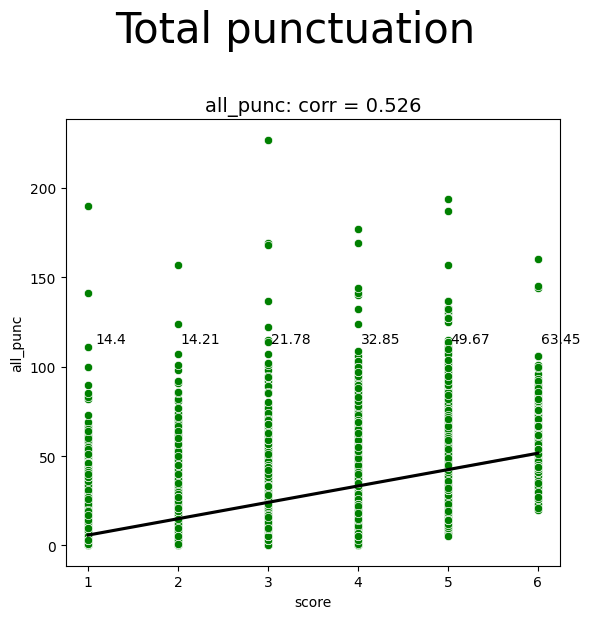

In [4]:
all_features = train.drop('score', axis=1)

train['all_punc'] = all_features.sum(axis=1)

# examines the correlations
correlation_analysis(train, 'all_punc', ncols=1, height=6, title='Total punctuation')

In [5]:
x = train.loc[:,'all_punc']

evaluate(pd.DataFrame(x), 10)


Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.46

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.45

Cohen Kappa Score: 0.47

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.46

Cohen Kappa Score: 0.47


Average: 0.474



## Only the strongest

We then test a feature including only the 3 strongest types of punctuation. The average score is higher (0.495) than previous methods.

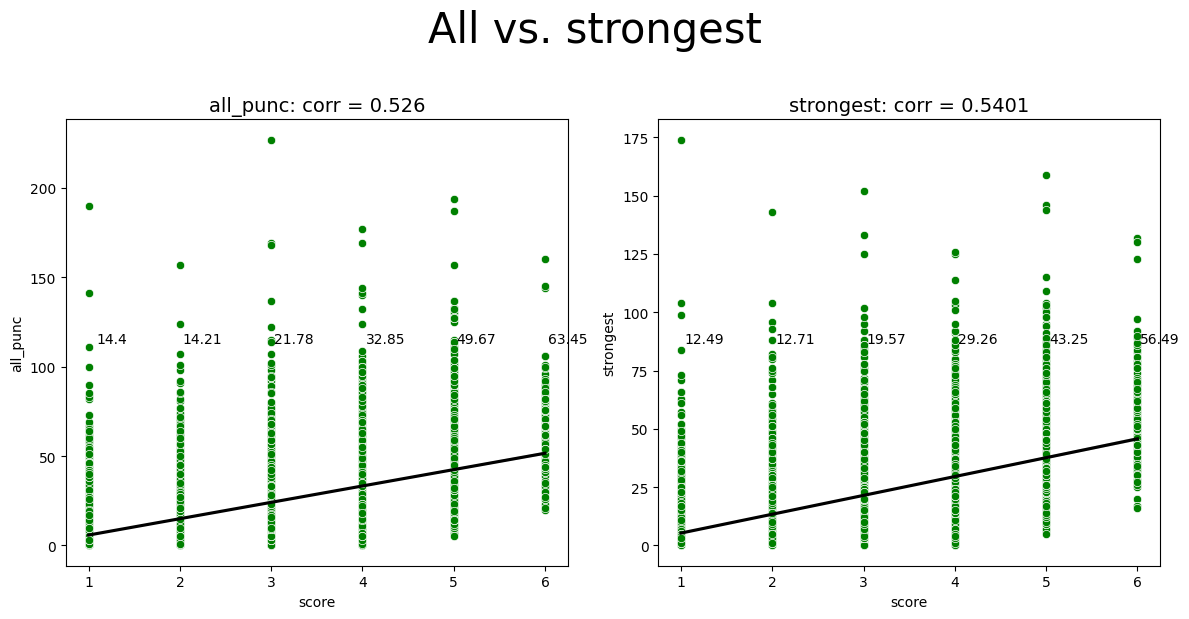

In [6]:
train['strongest'] = train['question_marks'] + train['comma'] + train['quotes']

# examines the correlations
correlation_analysis(train, ['all_punc', 'strongest'], ncols=2, height=6, title='All vs. strongest')

In [7]:
x = train.loc[:,'strongest']

evaluate(pd.DataFrame(x), 10)


Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.51

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.5


Average: 0.495



## Weakest as a seperate feature

Now, we include this strongest measure along with a separate measure including a count of all the weakest. This does not improve the average score (0.447).  

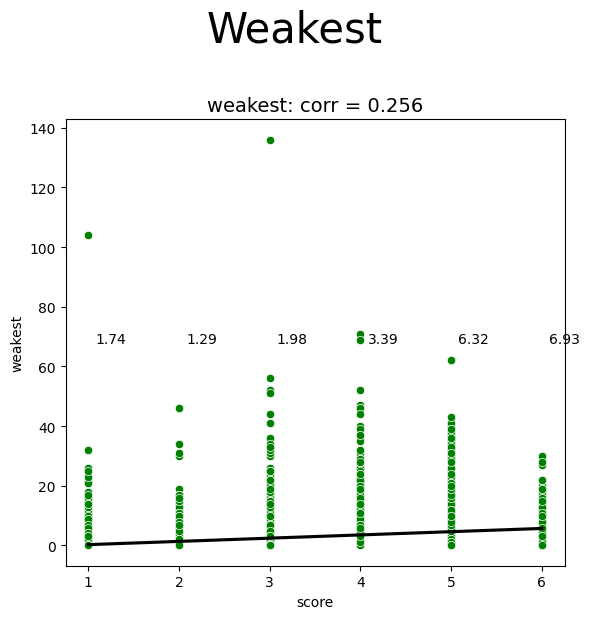

In [8]:
train['weakest'] = train['semi_colon'] + train['colon'] + train['square bracket'] + train['square bracket'] + train['parenthesis'] + train['hyphens'] 

# examines the correlations
correlation_analysis(train, 'weakest', ncols=1, height=6, title='Weakest')

In [9]:
x = train.loc[:,['strongest', 'weakest']]

evaluate(pd.DataFrame(x), 10)


Cohen Kappa Score: 0.45

Cohen Kappa Score: 0.42

Cohen Kappa Score: 0.46

Cohen Kappa Score: 0.45

Cohen Kappa Score: 0.44

Cohen Kappa Score: 0.45

Cohen Kappa Score: 0.44

Cohen Kappa Score: 0.47

Cohen Kappa Score: 0.43

Cohen Kappa Score: 0.44


Average: 0.447



## Weakest as a binary feature

Finally, we check whether it is more beneficial to include the weakest as a binary variable. This improves accuracy (0.488) from the previous measure (0.447) but not beyond that of the 3 strongest measure (0.495).

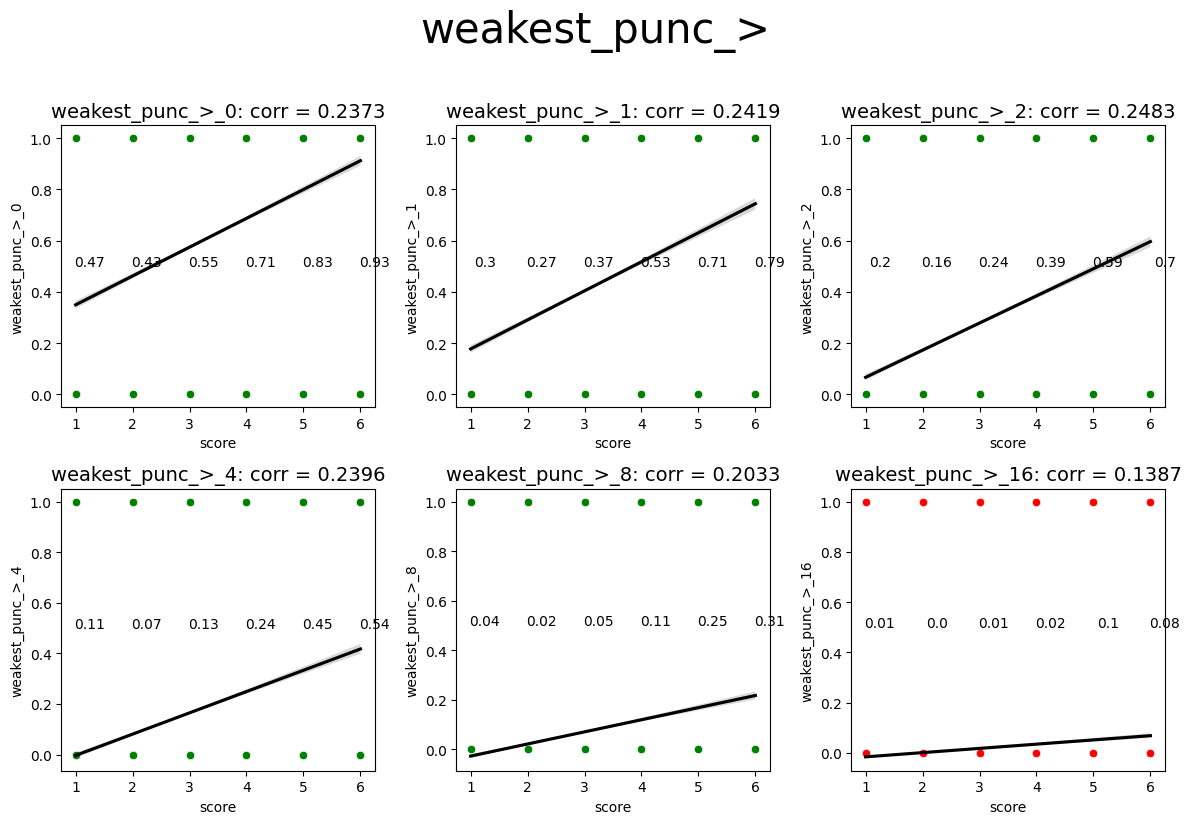

In [10]:
# creates new features for different cutoff values and assesses their efficacy
def adjust_reassess(base_feature, feature_name, cutoffs):

    # loops through each variation in the feature cutoff value and creates a new binary variable to be examined
    final_feature_names = []
    for cutoff in cutoffs:
        
        final_feature_name = feature_name + '_' + cutoff
        final_feature_names.append( final_feature_name )
        
        binary_feature = list(np.where(np.array(base_feature) > eval(cutoff), 1, 0))
        train[final_feature_name] = binary_feature
    
    # checks the correlation
    correlation_analysis(train, final_feature_names, title=feature_name)


# sets parameter values 
feature_name = 'weakest_punc_>'
cutoffs = ['0', '1', '2', '4', '8', '16']

adjust_reassess(base_feature=train['weakest'], feature_name=feature_name, cutoffs=cutoffs)

In [11]:
x = train.loc[:,['strongest', 'weakest_punc_>_2']]

evaluate(pd.DataFrame(x), 10)


Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.5

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.49

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.47

Cohen Kappa Score: 0.48

Cohen Kappa Score: 0.48


Average: 0.488



## Check for multicollinearity

Before implementing this feature, we check for multicollinearity with other features. The highest correlation is 0.27, which is not high enough to be a major concern.

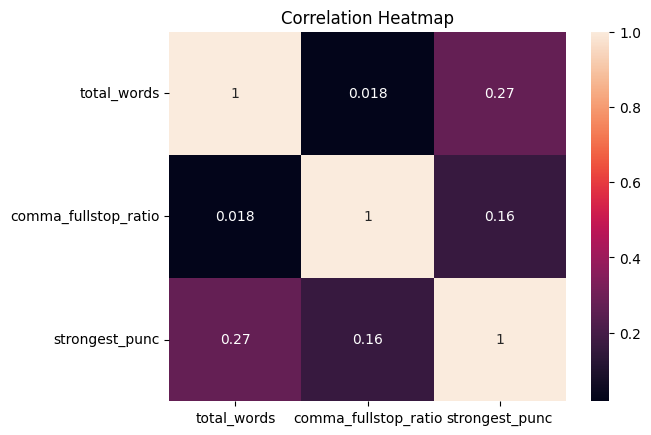

In [12]:
total_words = [len(x.split(' ')) for x in full_text]
comma_fullstop_ratio = [(x.count(',') + 0.1) / (x.count('.') + 0.1) for x in full_text]

# correlation dataframe
corr_df = pd.DataFrame({'total_words': total_words,
                        'comma_fullstop_ratio': comma_fullstop_ratio,
                        'strongest_punc': train['strongest']})

# matrix
correlation_matrix = corr_df.corr()


# heatmap
sns.heatmap(correlation_matrix, annot=True);
plt.title("Correlation Heatmap");
plt.show();

## Visualize results

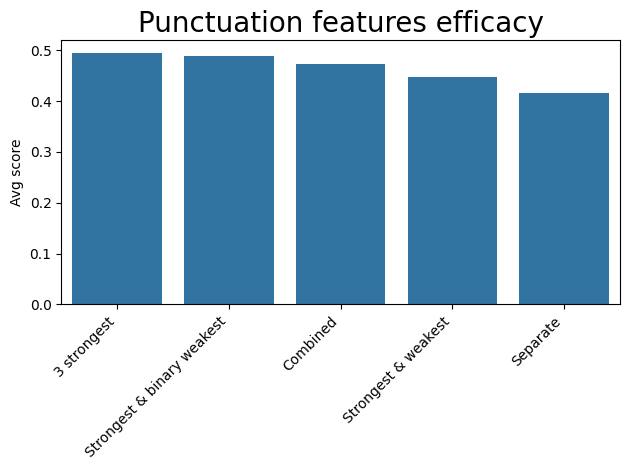

In [13]:
# plot data
name = ['Separate', 'Combined', '3 strongest', 'Strongest & weakest', 'Strongest & binary weakest']
value = [0.416, 0.474, 0.495, 0.447, 0.488]

# creates a dataframe
results_df = pd.DataFrame({'Name': name,
                           'Value': value})

# sorts the dataframe
results_df.sort_values('Value', ascending=False, inplace=True)

# creates a bar chart
sns.barplot(x="Name", y="Value", data=results_df);
plt.ylabel("Avg score");
plt.xlabel(None);
plt.title("Punctuation features efficacy", size=20);
plt.xticks(rotation=45, ha="right");  
plt.tight_layout();
plt.show();